# Admission Chance Prediction

### 1. Load and clean the data

In [184]:
import pandas as pd
import numpy as np 

# Load the dataset
df = pd.read_csv("admission_chance.csv")

# Drop 'Serial No' as it's just an identifier
df.drop(columns=['Serial No'], inplace=True)

# Rename column if there are trailing spaces
df.columns = df.columns.str.strip()  # fixes 'LOR ' to 'LOR'


In [185]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,3.860,1,0.92
1,324,107,4,4.0,4.5,3.548,1,0.76
2,316,104,3,3.0,3.5,3.200,1,0.72
3,322,110,3,3.5,2.5,3.468,1,0.80
4,314,103,2,2.0,3.0,3.284,0,0.65


In [186]:
df['Chance of Admit'] = (df['Chance of Admit'] >= 0.75).astype(int)

In [187]:
df['Chance of Admit'].value_counts()

Chance of Admit
0    220
1    180
Name: count, dtype: int64

In [188]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,3.860,1,1
1,324,107,4,4.0,4.5,3.548,1,1
2,316,104,3,3.0,3.5,3.200,1,0
3,322,110,3,3.5,2.5,3.468,1,1
4,314,103,2,2.0,3.0,3.284,0,0


### 2. Exploratory Data Analysis (EDA)

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt

Summary Statistics

In [190]:
df.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,316.807500,107.410000,3.087500,3.400000,3.452500,3.439570,0.547500,0.450000
std,11.473646,6.069514,1.143728,1.006869,0.898478,0.238527,0.498362,0.498117
min,290.000000,92.000000,1.000000,1.000000,1.000000,2.720000,0.000000,0.000000
25%,308.000000,103.000000,2.000000,2.500000,3.000000,3.268000,0.000000,0.000000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,3.444000,1.000000,0.000000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,3.625000,1.000000,1.000000
max,340.000000,120.000000,5.000000,5.000000,5.000000,3.968000,1.000000,1.000000


Check for missing values

In [191]:
print(df.isnull().sum())

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64


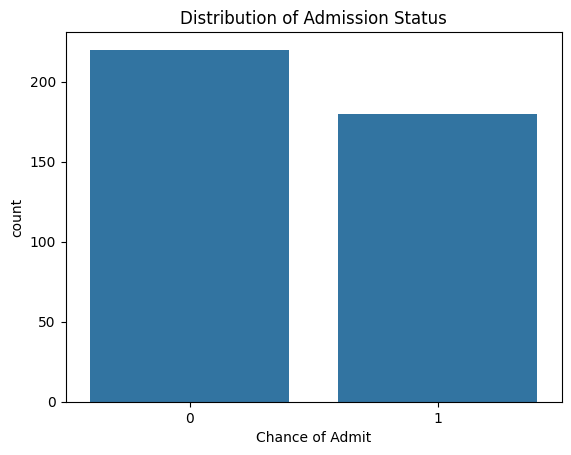

In [192]:
sns.countplot(x='Chance of Admit', data=df)
plt.title('Distribution of Admission Status')
plt.show()

Correlation heatmap

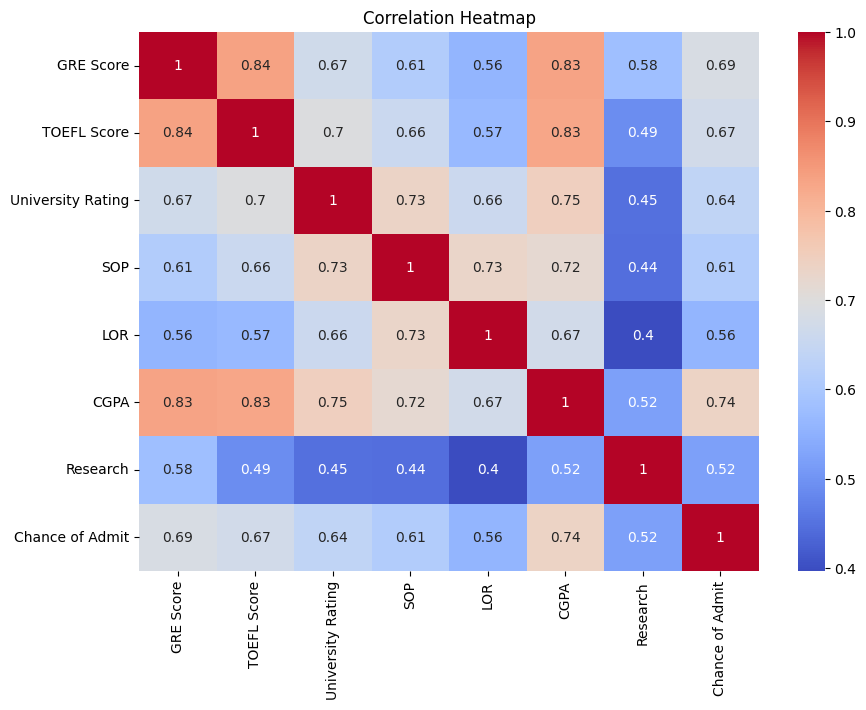

In [193]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Distribution of target variable

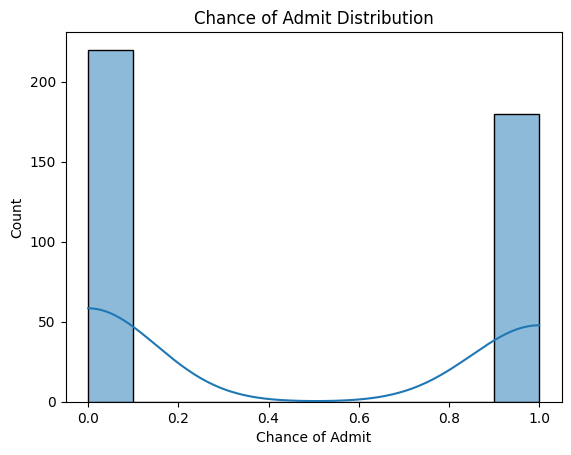

In [194]:
sns.histplot(df['Chance of Admit'], kde=True)
plt.title("Chance of Admit Distribution")
plt.show()

### 3. Preprocessing & Feature Engineering

In [195]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop("Chance of Admit", axis=1)
y = df["Chance of Admit"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 4. Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
import pickle

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

    

### 5. Feature Selection
We’ll use mutual information regression here:

In [197]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_train_scaled, y_train)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print(mi_series)


CGPA                 0.347178
GRE Score            0.316169
TOEFL Score          0.268119
SOP                  0.236387
University Rating    0.180719
LOR                  0.128732
Research             0.121594
dtype: float64


### 6. Model Training (Baseline & Evaluation)

In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)
# Evaluate 
acc_default = accuracy_score(y_pred,y_test )
print("Accuracy Score:", acc_default)


Accuracy Score: 0.9125


In [ ]:
# Column names exactly as in training data
cols = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']

# Create a DataFrame for the single sample
sample = pd.DataFrame([[337, 118, 4, 4.5, 4.5, 3.860, 1]], columns=cols)

sample = scaler.transform(sample)

# make prediction
prob = model.predict_proba(sample)
print(prob) # Output: [prob of no, prob of yes]

[[0.00224245 0.99775755]]


### 7. Hyperparameter Optimization: Identifying Optimal Parameter Values

In [200]:
from sklearn.model_selection import GridSearchCV

# Define the model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Define hyperparameters to tune
param_grid = [
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'newton-cg', 'sag'],
        'C': [0.1, 1, 10]
    },
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.1, 1, 10]
    },
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.5],  # or other values
        'C': [0.1, 1, 10]
    }
]


# Setup GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='roc_auc',    # Using AUC as the metric
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print(f"Best Parameters: {grid_search.best_params_}")

# Best score during CV
print(f"Best CV AUC Score: {grid_search.best_score_:.4f}")

# Use best estimator for predictions
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score

acc_tuned = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred))
print(f"Test ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print(f"Accuracy Score: {acc_tuned}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best CV AUC Score: 0.9432
              precision    recall  f1-score   support

           0       0.96      0.91      0.93        47
           1       0.89      0.94      0.91        33

    accuracy                           0.93        80
   macro avg       0.92      0.93      0.92        80
weighted avg       0.93      0.93      0.93        80

Test ROC AUC Score: 0.9884
Accuracy Score: 0.925


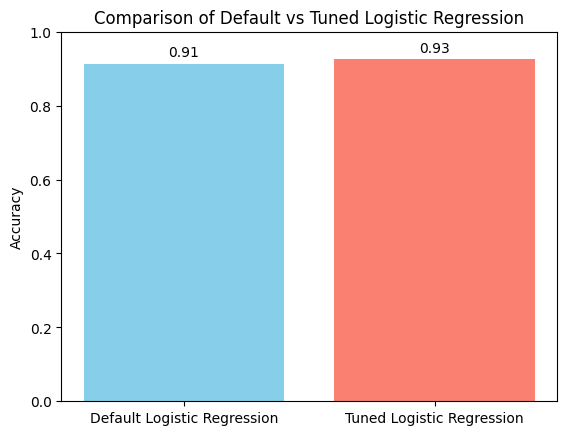

In [201]:
plt.bar(['Default Logistic Regression', 'Tuned Logistic Regression'], [acc_default, acc_tuned], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparison of Default vs Tuned Logistic Regression')
for i, acc in enumerate([acc_default, acc_tuned]):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')
plt.show()

### 9. Export the Model

In [206]:
import pickle

with open("model.pkl",'wb') as file:
    pickle.dump(best_model,file)

In [203]:
for column in X.columns:
    max_value = X[column].max()
    min_value = X[column].min()
    print(f"Column: {column}, Max: {max_value}, Min: {min_value}")

Column: GRE Score, Max: 340, Min: 290
Column: TOEFL Score, Max: 120, Min: 92
Column: University Rating, Max: 5, Min: 1
Column: SOP, Max: 5.0, Min: 1.0
Column: LOR, Max: 5.0, Min: 1.0
Column: CGPA, Max: 3.968, Min: 2.72
Column: Research, Max: 1, Min: 0


In [207]:
# Load the model
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

#  input data 
input_data = np.array([[300, 100, 3, 3, 3, 2, 1]])
input_data = scaler.transform(input_data)

# Predict class probabilities
probabilities = model.predict_proba(input_data)

print(probabilities) # [prob of yes, prob of no]

[[9.99461016e-01 5.38983558e-04]]


d:\Ao\Code\AI\ML-Playground\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
